In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import src

%matplotlib inline

In [5]:
df_tmdb = pd.read_csv('../zippedData/tmdb.movies.csv.gz', index_col=0)
df_budgets = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
df_rotten = pd.read_csv('rotten-sentiments.csv')
df_rotten.head()

,id,review,rating_x,fresh,critic,top_critic,publisher,date,synopsis,rating_y,genre,director,writer,theater_date,dvd_date,currency,box_office,sentiment
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",0.5574
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",-0.5423
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",0.0000
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",-0.7579
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",-0.4215


In [6]:
# Clean tmdb
df_tmdb.release_date = pd.to_datetime(df_tmdb.release_date)
df_tmdb['month_day'] = df_tmdb.release_date.dt.strftime("%m%d")
df_tmdb['month'] = df_tmdb.release_date.dt.strftime("%m")
df_tmdb['year'] = df_tmdb.release_date.dt.strftime("%Y").astype(int)
df_tmdb = df_tmdb[df_tmdb.year > 2009]
tmdb_grouped = df_tmdb.groupby(['month']).id.count()


In [7]:
# Clean Budget 
print(df_budgets.shape)
df_budgets.release_date = pd.to_datetime(df_budgets.release_date)
df_budgets['month_day'] = df_budgets.release_date.dt.strftime("%m%d")
df_budgets['month'] = df_budgets.release_date.dt.strftime("%m")
df_budgets['year'] = df_budgets.release_date.dt.strftime("%Y").astype(int)
df_budgets = df_budgets[df_budgets.year > 2009]
budgets_grouped = df_budgets.groupby(['month']).id.count()


(5782, 6)


In [8]:
# in order to see how many movies were released on a given day, we have to create a subset of the data with 1 entry per movie
df_no_dup_series = df_rotten.id.drop_duplicates()
df_rotten = df_rotten.iloc[df_no_dup_series.index]
df_rotten.shape


# Clean rotten data up for merging on a month_day column
df_rotten = df_rotten[df_rotten['theater_date'].notnull()]

# convert to datetime object
df_rotten.theater_date = pd.to_datetime(df_rotten.theater_date)


df_rotten['month'] = df_rotten.theater_date.dt.strftime("%m") 
df_rotten['day'] = df_rotten.theater_date.dt.strftime('%d')
df_rotten['year'] = df_rotten.theater_date.dt.strftime('%Y').astype(int)
df_rotten['month_day'] =  df_rotten.theater_date.dt.strftime('%m%d').astype(int)

df_rotten = df_rotten[df_rotten.year > 2009]
rotten_grouped = df_rotten.groupby(['month']).id.count()

In [9]:
df_rotten.head()

,id,review,rating_x,fresh,critic,top_critic,publisher,date,synopsis,rating_y,...,writer,theater_date,dvd_date,currency,box_office,sentiment,month,day,year,month_day
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018","New York City, not-too-distant-future: Eric Pa...",R,...,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,"600,000",0.5574,08,17,2012,817
471,14,A captivating film... [Full review in Spanish],3/5,fresh,Laura Hiros,0,NaN,"March 22, 2018","""Love Ranch"" is a bittersweet love story that ...",R,...,Mark Jacobson,2010-06-30,"Nov 9, 2010",$,"134,904",0.0000,06,30,2010,630
567,23,The movie is great. It is interesting without ...,8/10,fresh,Debbie Baldwin,0,Ladue News,"November 2, 2018",A fictional film set in the alluring world of ...,R,...,NaN,2013-12-20,"Mar 18, 2014",$,"99,165,609",0.8147,12,20,2013,1220
803,25,Anyone who might want characters and not clich...,C-,rotten,Stephen Schaefer,0,Boston Herald,"November 29, 2017","From ancient Japan's most enduring tale, the e...",PG-13,...,Chris Morgan|Hossein Amini,2013-12-25,"Apr 1, 2014",$,"20,518,224",-0.0941,12,25,2013,1225
1339,54,"It's just a life, full of strangeness and beau...",NaN,fresh,Molly Templeton,0,Eugene Weekly (OR),"August 28, 2018",Journalist Jep Gambardella (the dazzling Toni ...,NR,...,Paolo Sorrentino|Umberto Contarello,2013-11-15,"Mar 25, 2014",NaN,NaN,0.5859,11,15,2013,1115


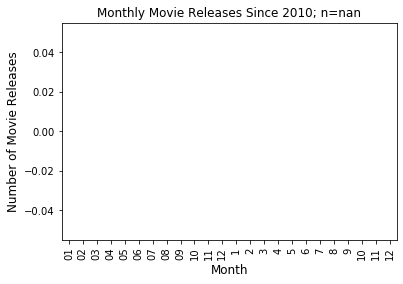

In [20]:
# I have 3 series that I would like to turn into 1 long series of their sums
monthly_series = rotten_grouped + budgets_grouped + tmdb_grouped
monthly_series.plot(kind='bar')
plt.ylabel('Number of Movie Releases', size= 12)
plt.xlabel('Month', size= 12)
plt.title(f'Monthly Movie Releases Since 2010; n={sum(monthly_series.values)}');

In [11]:





# Lets bring back rotten df and budget and look at the box office performance per month.
df_budgets = pd.read_csv('tn.movie_budgets.csv')
df_rotten = pd.read_csv('rotten-sentiments.csv')
df_tmdb = pd.read_csv('../zippedData/tmdb.movies.csv.gz', index_col=0)

FileNotFoundError: [Errno 2] File b'tn.movie_budgets.csv' does not exist: b'tn.movie_budgets.csv'

In [ ]:
print(src.get_iqr_median(df_tmdb, 'vote_count'))

In [12]:
# Let's look at popularity as a function of release date
# Clean tmdb
df_tmdb.release_date = pd.to_datetime(df_tmdb.release_date)
df_tmdb['month_day'] = df_tmdb.release_date.dt.strftime("%m%d")
df_tmdb['month'] = df_tmdb.release_date.dt.strftime("%m").astype(int)
df_tmdb['year'] = df_tmdb.release_date.dt.strftime("%Y").astype(int)
df_tmdb = df_tmdb[(df_tmdb.year > 2009) & (df_tmdb.vote_count > 150)]
tmdb_grouped = df_tmdb.groupby(['month']).popularity.mean()

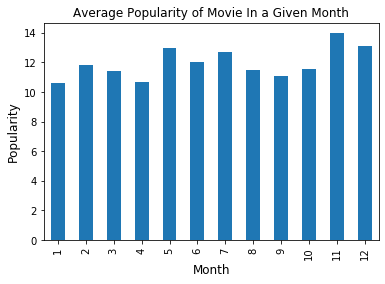

In [13]:
tmdb_grouped.plot(kind='bar')
plt.title("Average Popularity of Movie In a Given Month")
plt.ylabel("Popularity", size = 12);
plt.xlabel('Month', size = 12);

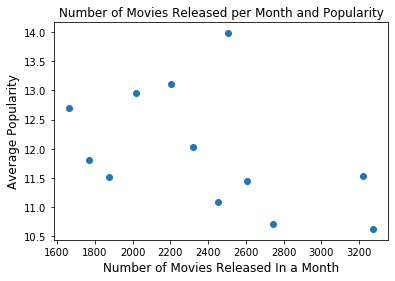

In [14]:
# Now let's plot popularity against release numbers
plt.scatter(monthly_series,tmdb_grouped)
plt.title("Number of Movies Released per Month and Popularity")
plt.xlabel("Number of Movies Released In a Month", size = 12)
plt.ylabel("Average Popularity", size = 12);

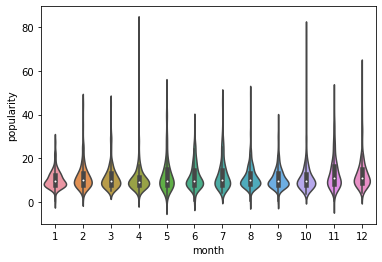

In [15]:
ax = sns.violinplot(x="month", y="popularity", data=df_tmdb)

In [16]:
df_tmdb.corr()

,id,popularity,vote_average,vote_count,month,year
id,1.000000,0.087892,0.071313,-0.115522,0.072482,0.907564
popularity,0.087892,1.000000,0.216534,0.694280,0.085307,0.209375
vote_average,0.071313,0.216534,1.000000,0.310862,0.129654,0.056147
vote_count,-0.115522,0.694280,0.310862,1.000000,0.084450,-0.000014
month,0.072482,0.085307,0.129654,0.084450,1.000000,-0.010966
year,0.907564,0.209375,0.056147,-0.000014,-0.010966,1.000000


In [17]:
# Let's look at budgets in a given month
df_budgets.release_date = pd.to_datetime(df_budgets.release_date)
df_budgets['month_day'] = df_budgets.release_date.dt.strftime("%m%d").astype(int)
df_budgets['month'] = df_budgets.release_date.dt.strftime("%m").astype(int)
df_budgets['year'] = df_budgets.release_date.dt.strftime("%Y").astype(int)
df_budgets = df_budgets[(df_budgets.year > 2009)]
df_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,month_day,month,year
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",520,5,2011
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",607,6,2019
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",501,5,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",1215,12,2017
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220",1218,12,2015


In [18]:
df_budgets['roi'] = (df_budgets['worldwide_gross']-df_budgets['production_budget'])/df_budgets['production_budget']

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [19]:
monthly_number_map_dict = {}
monthly_series.value_counts()
for month, number in zip(monthly_series.index, monthly_series.values):
    monthly_number_map_dict[int(month)] = number
monthly_number_map_dict

{1: 3274,
 2: 1770,
 3: 2604,
 4: 2743,
 5: 2019,
 6: 2322,
 7: 1662,
 8: 1873,
 9: 2451,
 10: 3220,
 11: 2503,
 12: 2204}

In [103]:
df_budgets['monthly_release']=df_budgets.month.apply(lambda x: monthly_number_map_dict[x])

In [104]:
df_budgets.corr()

,id,production_budget,domestic_gross,worldwide_gross,month_day,month,year,roi,monthly_release
id,1.000000,-0.058677,-0.018137,-0.029658,-0.016824,-0.016592,0.024780,0.032374,-0.022207
production_budget,-0.058677,1.000000,0.732027,0.793638,-0.006604,-0.005945,0.078174,-0.009964,-0.109772
domestic_gross,-0.018137,0.732027,1.000000,0.946190,0.001744,0.003324,0.078724,0.133871,-0.098325
worldwide_gross,-0.029658,0.793638,0.946190,1.000000,0.003123,0.004323,0.079775,0.122344,-0.095865
month_day,-0.016824,-0.006604,0.001744,0.003123,1.000000,0.999685,-0.040289,-0.018829,-0.060905
month,-0.016592,-0.005945,0.003324,0.004323,0.999685,1.000000,-0.039759,-0.018122,-0.060704
year,0.024780,0.078174,0.078724,0.079775,-0.040289,-0.039759,1.000000,0.021452,-0.001976
roi,0.032374,-0.009964,0.133871,0.122344,-0.018829,-0.018122,0.021452,1.000000,-0.012702
monthly_release,-0.022207,-0.109772,-0.098325,-0.095865,-0.060905,-0.060704,-0.001976,-0.012702,1.000000


In [105]:
# in order to see how many movies were released on a given day, we have to create a subset of the data with 1 entry per movie
df_no_dup_series = df_rotten.id.drop_duplicates()
df_rotten = df_rotten.iloc[df_no_dup_series.index]
df_rotten.shape


# Clean rotten data up for merging on a month_day column
df_rotten = df_rotten[df_rotten['theater_date'].notnull()]

# convert to datetime object
df_rotten.theater_date = pd.to_datetime(df_rotten.theater_date)


df_rotten['month'] = df_rotten.theater_date.dt.strftime("%m") 
df_rotten['day'] = df_rotten.theater_date.dt.strftime('%d')
df_rotten['year'] = df_rotten.theater_date.dt.strftime('%Y').astype(int)
df_rotten['month_day'] =  df_rotten.theater_date.dt.strftime('%m%d')

df_rotten = df_rotten[(df_rotten.year > 2009)]

In [106]:
sentiment_grouped = df_rotten.groupby(['month']).sentiment.median()

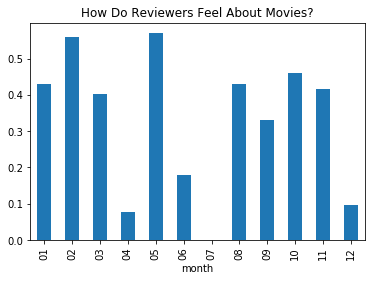

In [107]:
sentiment_grouped.plot(kind = 'bar')
plt.title('How Do Reviewers Feel About Movies?');

In [108]:
negativity = df_rotten.groupby(['publisher']).sentiment.median().sort_values()[:10]

''

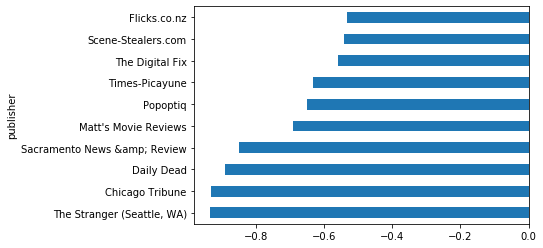

In [109]:
negativity.plot(kind='barh')
; 

In [110]:
df_sentiment =sentiment_grouped.reset_index()
df_sentiment.month =df_sentiment.month.astype(int)

df_monthly_series = monthly_series.reset_index()
df_monthly_series.columns = ['Month', 'Number of Movies']

NameError: name 'df_monthly_series' is not defined

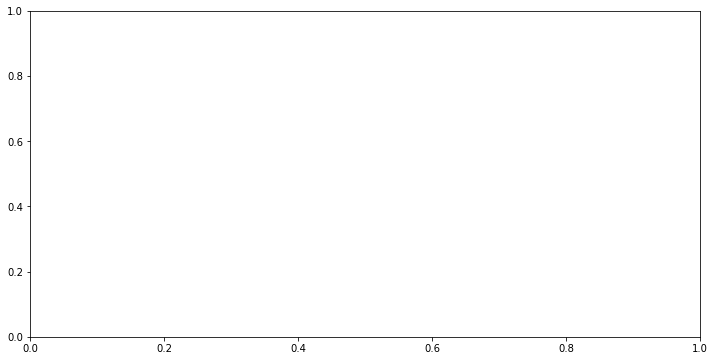

In [21]:
# Plot monthly release and sentiment value on the same plot\
# Convert monthly_series back to dataframe
monthl_number_df = monthly_series.reset_index()

# ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = df_monthly_series, x='Month', y='Number of Movies', alpha=0.5, ax=ax1)
ax1.set_xlabel(f'Month', size = 12)
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Sentiment Score')
ax2.legend('A simple line')

sns.lineplot(data = df_sentiment['sentiment'], marker='o', sort = False, ax=ax2);


In [112]:
negativity.append(monthl_number_df)

,0,id,month
"The Stranger (Seattle, WA)",-0.9344,NaN,NaN
Chicago Tribune,-0.9300,NaN,NaN
Daily Dead,-0.8910,NaN,NaN
Sacramento News &amp; Review,-0.8481,NaN,NaN
Matt's Movie Reviews,-0.6908,NaN,NaN
Popoptiq,-0.6486,NaN,NaN
Times-Picayune,-0.6305,NaN,NaN
The Digital Fix,-0.5574,NaN,NaN
Scene-Stealers.com,-0.5423,NaN,NaN
Flicks.co.nz,-0.5334,NaN,NaN


In [113]:
# We need to create a genre's data frame, similar to what we have for the imdb work.

# Coerce the data frame
df_rotten.head()

,id,review,rating_x,fresh,critic,top_critic,publisher,date,synopsis,rating_y,...,writer,theater_date,dvd_date,currency,box_office,sentiment,month,day,year,month_day
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018","New York City, not-too-distant-future: Eric Pa...",R,...,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,"600,000",0.5574,08,17,2012,0817
471,14,A captivating film... [Full review in Spanish],3/5,fresh,Laura Hiros,0,NaN,"March 22, 2018","""Love Ranch"" is a bittersweet love story that ...",R,...,Mark Jacobson,2010-06-30,"Nov 9, 2010",$,"134,904",0.0000,06,30,2010,0630
567,23,The movie is great. It is interesting without ...,8/10,fresh,Debbie Baldwin,0,Ladue News,"November 2, 2018",A fictional film set in the alluring world of ...,R,...,NaN,2013-12-20,"Mar 18, 2014",$,"99,165,609",0.8147,12,20,2013,1220
803,25,Anyone who might want characters and not clich...,C-,rotten,Stephen Schaefer,0,Boston Herald,"November 29, 2017","From ancient Japan's most enduring tale, the e...",PG-13,...,Chris Morgan|Hossein Amini,2013-12-25,"Apr 1, 2014",$,"20,518,224",-0.0941,12,25,2013,1225
1339,54,"It's just a life, full of strangeness and beau...",NaN,fresh,Molly Templeton,0,Eugene Weekly (OR),"August 28, 2018",Journalist Jep Gambardella (the dazzling Toni ...,NR,...,Paolo Sorrentino|Umberto Contarello,2013-11-15,"Mar 25, 2014",NaN,NaN,0.5859,11,15,2013,1115


In [115]:
df_rotten = pd.read_csv('rotten-sentiments.csv')
# remove null values from genre
df_rotten = df_rotten[df_rotten.genre.notnull()]

# in order to see how many movies were released on a given day, we have to create a subset of the data with 1 entry per movie
df_no_dup_series = df_rotten.id.drop_duplicates()
df_rotten = df_rotten.iloc[df_no_dup_series.index]
df_rotten.shape


# Clean rotten data up for merging on a month_day column
df_rotten = df_rotten[df_rotten['theater_date'].notnull()]

# convert to datetime object
df_rotten.theater_date = pd.to_datetime(df_rotten.theater_date)


df_rotten['month'] = df_rotten.theater_date.dt.strftime("%m") 
df_rotten['day'] = df_rotten.theater_date.dt.strftime('%d')
df_rotten['year'] = df_rotten.theater_date.dt.strftime('%Y').astype(int)
df_rotten['month_day'] =  df_rotten.theater_date.dt.strftime('%m%d')

df_rotten = df_rotten[(df_rotten.year > 2009)]

In [116]:
#coerce the genres column to a list
df_rotten['genres']=df_rotten.genre.apply(lambda x: re.split("and|\|",x))

In [117]:
# Create our dataframe
df_rotten_genres = src.generate_genre_dataframe(df_rotten)
df_rotten_genres.drop(columns= [
    'rating_x',
    'review',
    'genre',],
                     inplace=True)

In [119]:
df_rotten_genres.month

0        08
471      06
567      12
803      12
1339     11
         ..
47386    01
47844    12
48011    07
48014    02
48321    10
Name: month, Length: 160, dtype: object